# 1. Data 

In [74]:
%pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [75]:
import ijson
import heapq
import networkx as nx
import pandas as pd
import itertools
from itertools import combinations
from collections import Counter

import pickle
import heapq
from prettytable import PrettyTable


## Data pre-processing

#### The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.

#### Identify the top 10,000 papers with the highest number of citations.

First we read in one item of our json file to get a feeling for our data

In [20]:
counter = 0
limit = 1 # Number of objects to read
dato=[]

with open("dblp.v12.json", 'rb') as f:
    for record in ijson.items(f, 'item'):
        if counter >= limit:
            break
        # Process the record here
        dato.append(record)
        counter += 1

In [21]:
dato

[{'id': 1091,
  'authors': [{'name': 'Makoto Satoh',
    'org': 'Shinshu University',
    'id': 2312688602},
   {'name': 'Ryo Muramatsu', 'org': 'Shinshu University', 'id': 2482909946},
   {'name': 'Mizue Kayama', 'org': 'Shinshu University', 'id': 2128134587},
   {'name': 'Kazunori Itoh', 'org': 'Shinshu University', 'id': 2101782692},
   {'name': 'Masami Hashimoto', 'org': 'Shinshu University', 'id': 2114054191},
   {'name': 'Makoto Otani', 'org': 'Shinshu University', 'id': 1989208940},
   {'name': 'Michio Shimizu',
    'org': 'Nagano Prefectural College',
    'id': 2134989941},
   {'name': 'Masahiko Sugimoto',
    'org': 'Takushoku University, Hokkaido Junior College',
    'id': 2307479915}],
  'title': 'Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map',
  'year': 2013,
  'n_citation': 1,
  'page_start': '89',
  'page_end': '93',
  'doc_type': 'Conference',
  'publisher': 

In order to get the 10000 papers with the most citations we read in every paper(itself a dictionnary) and only store the id of the paper (to recognize it later) and the number of references in a dictionnary.

In [22]:
with open('dblp.v12.json', 'r') as f:
    papers = ijson.items(f, 'item')
    new_dict = {}
    for d in papers:
        id = d["id"]
        num_citations = d["n_citation"] if "n_citation" in d else 0
        new_dict[id] = num_citations

Now we want to sort our dictionnary. We do this by creating tuples of our key/value pairs and storing them in a list. Then it is sorted by the second element of each tuple (number of citations) in descending order.

In [23]:
sorted_dict = sorted(new_dict.items(), key=lambda x:x[1], reverse=True)

We only want the 10000 papers with the most citations, that's why only consider the first 10000 tuples in our list. It is possible, that there are papers ingored that have the same number of citations as some that are kept. We are consciously ignoring this.

In [24]:
sorted_dict = sorted_dict[0:10000]

In [25]:
sorted_dict

[(2041404167, 48327),
 (1639032689, 44175),
 (2912565176, 42437),
 (2151103935, 35541),
 (2911964244, 34741),
 (1973948212, 32053),
 (2153635508, 31047),
 (2156909104, 28886),
 (1791587663, 25855),
 (2119821739, 22276),
 (1995875735, 22122),
 (2103441770, 21301),
 (2126105956, 21153),
 (2146058063, 20976),
 (2108234281, 20162),
 (2145023731, 19801),
 (2161969291, 19433),
 (2171074980, 19427),
 (1880262756, 19392),
 (2137015675, 18732),
 (2082928585, 18098),
 (1686810756, 18029),
 (1522301498, 17497),
 (2133665775, 17339),
 (2161444534, 17261),
 (2121863487, 17231),
 (2132629607, 17135),
 (2011039300, 17118),
 (2163605009, 16802),
 (2132984323, 16652),
 (2064675550, 16450),
 (2125055259, 16276),
 (2085261163, 15271),
 (2296616510, 15261),
 (2169528473, 15226),
 (2194775991, 15184),
 (1667165204, 14972),
 (2079325629, 14797),
 (2100379340, 14775),
 (2104095591, 14470),
 (1595159159, 14257),
 (2133990480, 13917),
 (2173213060, 13866),
 (2159080219, 13820),
 (2139212933, 13522),
 (21246374

Now we extract the id's we are interested in and store it in a list

In [26]:
relevant_ids= [tup[0] for tup in sorted_dict]

Now we have what we need to extract the 10000 papers with the most citations from our json file. We store them in a list called graph_list. This is a list of dictionnaries. Alternatively we could have also just extracted the information that was necessary to construct the graph.

In [27]:
with open('dblp.v12.json', 'r') as f:
    papers = ijson.items(f, 'item')
    graph_list = []
    for paper in papers:
        if paper['id'] in relevant_ids:
            graph_list.append(paper)  
      

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/c4/zpw_p5ls3fl74l16gzt_y7l00000gn/T/ipykernel_2736/1058928506.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py",

## Graphs setup



#### Citation graph: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B. Nodes: You can consider each of the papers as your nodes. Edges: Only consider the citation relationship between these 10,000 papers and ignore the rest


In [ ]:
#Citation graph
#Initializes a directed graph, that can have double edges
G= nx.MultiDiGraph()
#Creating the nodes
for paper in graph_list:
    G.add_node(paper['id'])
#Creating the edges
for paper in graph_list:
    #Condition to avoid error as it is possible that a paper has no citations
    if 'references' in paper:
        for element in paper['references']:
            # Condition to verify that only the citation relationship of the top 10000 papers is being looked at
            if element in relevant_ids:
                G.add_edge(paper['id'],element)

#### Collaboration graph: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.  Nodes: The authors of these papers would be your nodes. Edges: Only consider the collaborations between the authors of these 10,000 papers and ignore the rest.

The creation of the collaboration graph is a little bit more complicted, therefor we split in several steps

First we initialize an undirected graph

In [ ]:
#Initialization of the collaboration graph
N= nx.Graph()    

Now we are creating the nodes. Therefor we iterate through our list of dictionnaries(our papers) and save them in a list. This list is later converted to a set to avoid creating the same node several times.

In [ ]:
#Initialization of empty list
author_list=[]
#Extracting the authors
for paper in graph_list:
    for author in paper['authors']:
        author_list.append(author['id'])
#Cooveritng it to a set
nodes=set(author_list)
#Creating the nodes
for node in nodes:
    N.add_node(node)

Now we have to create the edges. We consider it a collabortaion if two authors worked on a paper together.We consider a collaboration as stronger if the authors worked together on many papers.Therefor our weight will be the number of times two authors worked together. To show these collaborations by edges we write two helping functions.

As for a lot of papers there are several authors, we want to create tuples of each combination of authors (edges). Our permutation function helps us doing that.

In [ ]:
def permutation(list_authors_pp):
    # Sort the tuples to make sure they are always created in the same order
    sorted_list_authors_pp= sorted(list_authors_pp)
    #Create tuples of all posible combinations and store them in a list
    all_combinations = list(combinations(sorted_list_authors_pp, 2))
    # Store the tuples in combination_list
    for combo in all_combinations:
        combination_list.append(combo)


Our second function counts the occurence of each tuple and returns a list of tuples. The first element of each tuple is a tuple that contains the id's of the two authors (edge). The second element of each tuple is the number of times the two authors worked together (weight).

In [ ]:
def count_tuples(tuple_list):
    #Count the tuples (collaborations) 
    counter = Counter(tuple_list)
    #Store the new tuples in a list
    result_list = [(key, (count)) for key, count in counter.items()]
    return result_list


Now that we have our two helping functions, we create our weighted edges. We iterate through the authors of the individual papers (dictionnaries) and get the collaboration combinations of the authors for every single paper. We count the occurence of every single collaboration between two authors, which will be the weight of the edges, that we then create.

In [ ]:
#Initialize list for collaboration combinations
combination_list=[]

#Iterate through the papers
for paper in graph_list:

    #Initialize list for the author id's of a single paper
    list_authors_pp=[]

    for author in paper['authors']:
        list_authors_pp.append(author['id'])
        
    #Get the author pairs (collaborations) of a single paper
    permutation(list_authors_pp)
    
#Count all the tupes and create a new tuple with weights
tuples_weighted= count_tuples(combination_list)

#Create the edges
for tuplo in tuples_weighted:
    N.add_edge(tuplo[0][0], tuplo[0][1], weight=tuplo[1])


__________

G is the citations' graph     
N is the collaboration graph - N.nodes() stored as a set under variable "nodes" (these are the authors' ids)

In [ ]:
# Retrieve data of the collaboration graph and store it in a convinient format
collaboration_nodes = list(nodes)
collaboration_edges = [t[0] for t in tuples_weighted]
collaboration_weigths = dict({t[0]: t[1] for t in tuples_weighted})

collaboration_data = {'nodes': collaboration_nodes, 'edges': collaboration_edges, 'weigths': collaboration_weigths, 'dir': False}

#retrieve citations' graph data and store it
citation_nodes = list(G.nodes())
citation_edges = list(G.edges())

citation_data = {'nodes': citation_nodes, 'edges': citation_edges, 'weigths' : dict(), 'dir': True}

# save graphs data as pikle file 
with open('collaboration.pkl', 'wb') as fp:
    pickle.dump(collaboration_data, fp)

fp.close()

with open('citation.pkl', 'wb') as fp:
    pickle.dump(citation_data, fp)

fp.close()

In [ ]:
# Dictionary with the data of the top 10.000 papers
graph_data = dict()
for graph_item in graph_list:
    graph_data.update({graph_item['id']: graph_item})

with open('graphdata.pkl', 'wb') as f:
    pickle.dump(graph_data, f)

f.close()

___________

# RUN FROM HERE

In [2]:
file = open("citation.pkl",'rb')
citation_data = pickle.load(file)
file.close()

file = file = open("collaboration.pkl",'rb')
collaboration_data = pickle.load(file)
file.close()

Defining class graph for next functionalities

In [3]:
class graph:
    def __init__(self, V: list, E: list, attributes: dict, directed: bool):
        self.nodes = V
        self.edges = E
        self.edges_attributes = attributes
        
        # Flag to indicate if the graph is directed
        self.isdirected = directed
    
    def set_edges_attribute(self, edges, values, name=None):
        attribute_dict = dict.fromkeys(self.edges, None)
        for (edge, value) in zip(edges, values):
            attribute_dict[edge] = value
            self.edges_attributes.update({name : attribute_dict})
    
    def extract_subgraph(self, subgraph_nodes):
        # The subgraph will be directed iff the original graph is directed
    
        # retrieve edges with both end in the list of nodes of the subgraph
        subgraph_edges = [edge for edge in self.edges if (edge[0] in subgraph_nodes and edge[1] in subgraph_nodes) ]

        # Update attributes for the subraph
        subgraph_attributes = dict()
        for attribute in self.edges_attributes: 
            original_attribute = self.edges_attributes[attribute]
            subgraph_attributes[attribute] = {edge: original_attribute[edge] for edge in subgraph_edges}

        subgraph = graph(subgraph_nodes, subgraph_edges, subgraph_attributes, self.isdirected)
        return subgraph

    def remove_edges(self, edges_todel_list):
        # old edges
        edges = self.edges

        # list containing the old edges without the ones to delete
        new_edges = [edge for edge in edges if edge not in edges_todel_list]
        
        # set new edges as 'edges' attribute of the graph
        self.edges = new_edges

    def get_neighborhood(self, vertex): # Different cases if the graph is directed or not
        if self.isdirected:
            neigborhood = [edge[1] for edge in self.edges if edge[0] == vertex]
            return neigborhood
        
        # not directed case
        neigborhood = [edge[1] for edge in self.edges if edge[0] == vertex] + [edge[0] for edge in self.edges if edge[1] == vertex]
        neigborhood = list(set(neigborhood))

        return neigborhood
    
    def neighborhood_withedges_onlyundirected(self, vertex):
        if not self.isdirected:
            neigborhood_withedges = {edge[1]: edge for edge in self.edges if edge[0] == vertex}
            neigborhood_withedges.update({edge[0]: edge for edge in self.edges if edge[1] == vertex})

            return neigborhood_withedges

    def indegree(self, node):
        if self.isdirected:
            indegree = len([edge for edge in self.edges if edge[1] == node])
            return indegree
        
        
    def to_directed(self):
        if self.isdirected:
            return self
        
        new_edges = set(edge[::-1] for edge in self.edges)
        total_edges = list(set(self.edges).union(new_edges))
        self.edges = total_edges

        new_edges = list(new_edges)
        updated_attributes = dict()
        for attribute in self.edges_attributes:
            attr_dict = self.edges_attributes[attribute]
            new_edges_attr = dict({new_edge: attr_dict[new_edge[::-1]] for new_edge in new_edges})
            new_edges_attr.update(attr_dict)
            updated_attributes.update( { attribute: new_edges_attr } )

        self.edges_attributes = updated_attributes
        self.isdirected = True
        return self
    
    def copy(self):
        return graph(self.nodes, self.edges, self.edges_attributes, self.isdirected)
    

Define functions to extract top N papers and top N authors.

- TopN papers: N papers with more citations
- TopN authors: N authors with more publications

How to retriev this info: 
- in the collaboration graph (authors' graph), the total number of publications of each author an be retrieved as the sum of the weigths adjacent to the author's node; then we can store these info and retrieve the topN authors with a heap structure, then induce a subgraph and work on it.
- in the citation graph (papers' graph), the number of citation of each paper can be retrieved as the indegree of the node correspinding to it; then heap + topN + subgraph.

In [4]:
def extract_topN(G, N, flag):

    # Function to retrieve the top N papers wrt number of citations
    def topN_papers(G, N):
        # create list of tuples (node, indegree(node)) for heapq
        nodes_indegree = []
        for node in G.nodes: 
            nodes_indegree.append((node, G.indegree(node)))
        
        # retrieve topN papers
        nlargest = heapq.nlargest(N, nodes_indegree, key= lambda t: t[1])

        # return only the nodes with the most  number of citations
        return [t[0] for t in nlargest]

    # Function to retrieve top N authors wrt their total number of publications
    def topN_authors(G, N):

        # initialize empty list 
        n_publications = []

        # Retrieve all the edges' weigths of the graph
        all_weigths = G.edges_attributes['weigths']

        # retrieve number of publications for each node
        #  dictionary {node: {Neighbor: edge between neighbor and node} for all the neighbors of the node}
        all_nodes_neigh_withedges = dict({node: G.neighborhood_withedges_onlyundirected(node) for node in G.nodes})
        
        for node in G.nodes: 
            # Retrieve info on the current node
            current_node_info = all_nodes_neigh_withedges[node]

            # Construct dictionary {Neighbor: weigth of the edge between neighbor and node} for all the neighbors of the node:
            # Initialize dictionary with all the weigths set to 0
            neigh_weigths_dict = dict.fromkeys(current_node_info.keys(), 0)
            # Update the dictionary with the correct weights
            neigh_weigths_dict.update({neigh: all_weigths[current_node_info[neigh]] for neigh in current_node_info if current_node_info[neigh] in all_weigths})

            # Update the list of the number of publications for each node
            n_publications.append( ( node, sum( neigh_weigths_dict.values() ) ) )

        # Retrieve top N authors wrt their total number of publications
        nlargest = heapq.nlargest(N, n_publications, key= lambda t: t[1])

        # Return only the nodes (without number of publications)
        return [t[0] for t in nlargest]


    if flag == 'authors':
        topN = topN_authors(G, N)
    elif flag == 'papers': 
        topN = topN_papers(G, N)
    else:
        return 'invalid flag'
    
    return topN


________

2.4 Disconnect a graph - with DFS

On authors' graph (collaboration graph): weighted and undirected.

In [5]:
def checkpath_DFS(G, source, sink):
    
    # initialize empty path
    path = []

    # set 'visited' to false for every node in the graph
    visited = dict.fromkeys(G.nodes, False)

    # initilize a stack with only the source and set visited to true for source
    S = [source]
    #visited[source] = True

    while S and not visited[sink]:
        u = S.pop(0)
        # Check if u is already been visited
        if not visited[u]:
            # If not, explore u's neighborhood
            neighborhood = G.get_neighborhood(u)
            if neighborhood == []:
                return visited[sink], path

            for neighbour in neighborhood: 
                if G.edges_attributes['capacity'][(u, neighbour)] > 0 :
                    S.insert(0, neighbour)
            
            # last neighbour inserted will be the first explored at next step 
            path.append( ((u, neighbour), G.edges_attributes['capacity'][(u, neighbour)]) )
            
            # Check if we arrived to the sink 
            if neighbour == sink:
                visited[sink] = True
            
            # Now u has been visited
            visited[u] = True

    # If there's a path from source to sink, visited[sink] will be true, elseway false 
    return visited[sink], path

def FordFulkerson(G, source, sink):
    
    # Construct residual graph from the starting one
    G_res = G.copy().to_directed()
    
    # initialize the flow to zero for all the edges
    original_edges = list(G_res.edges)
    flow = dict.fromkeys(original_edges, 0)
    G_res.edges_attributes.update({'flow': flow})

    # initialize capacity (starting weigths)
    capacity = G_res.edges_attributes['weigths']
    G_res.edges_attributes.update({'capacity': capacity})

    while  checkpath_DFS(G_res, source, sink)[0]:

        # find a simple sink-source path 
        _, path = checkpath_DFS(G_res, source, sink)
        
        # obtain bottleneck on the path
        bottleneck = min([edge[1] for edge in path]) # edge(1) is the capacity of the edge
        
        # augment capacity 
        for edge in path:
            # Update flow
            flow.update({edge[0]: flow[edge[0]] + bottleneck})
            flow.update({edge[0][::-1] : -flow[edge[0]]})

            # Update capacity
            capacity.update({edge[0]: capacity[edge[0]] - flow[edge[0]]}) 
            capacity.update({edge[0][::-1] : capacity[edge[0][::-1]] + flow[edge[0]]  })

        # Update G-res
        G_res.edges_attributes.update({'capacity': capacity})
        G_res.edges_attributes.update({'flow': flow})
        G_res.remove_edges([ edge for edge in capacity if capacity[edge] <= 0])


    return G_res


def node_connected_component(G, node):
        
        # Initialize visited dictionary
        visited = dict.fromkeys(G.nodes, False)
        
        # intialize empty component
        component = []

        # initilize a stack with only the node in input 
        S = [node]

        while S != []:
            # select first element of the stack
            u = S.pop(0)

            # Check if u is already been visited
            if not visited[u]:
                # If not, add u to the current component and "explore" u's neighborhood
                component.append(u)
                
                neighborhood = G.get_neighborhood(u)
                for neighbour in neighborhood:
                    S.insert(0, neighbour)
                
                visited.update({u: True})
                
        
        return component

In [6]:
def disconnect(N, authorA, authorB, G_data=collaboration_data):
    # extract graph class instance from the data in input 
    G = graph(G_data['nodes'], G_data['edges'], {'weigths': G_data['weigths']}, G_data['dir'])

    # extract top N authors 
    topN_list = extract_topN(G, N, 'authors')

    # subgraph of the top N authors
    G_N = G.extract_subgraph(topN_list)
    
    # Run FordFulkerson algorithm 
    G_res_final = FordFulkerson(G_N, authorA, authorB)

    # Construct the cut (G_authorA, G_authorB)
    nodes_authorA = node_connected_component(G_res_final, authorA)
    nodes_authorB = list(set(G_N.nodes).difference(set(nodes_authorA)))


    # Cut capacity 
    cutset = [ edge for edge in G_N.edges if edge[0] in nodes_authorA and edge[1] in nodes_authorB ] + [ edge for edge in G_N.edges if edge[1] in nodes_authorA and edge[0] in nodes_authorB ] 
    cutcapacity = sum([G_N.edges_attributes['weigths'][edge] for edge in cutset])
   
    return cutcapacity, cutset, len(cutset)

In [37]:
# extract graph class instance from the data in input 
G = graph(collaboration_data['nodes'], collaboration_data['edges'], {'weigths': collaboration_data['weigths']}, collaboration_data['dir'])

In [40]:
list(G.edges_attributes['weigths'].items())[0]

((2114878774, 2149556533), 1)

In [52]:
# extract graph class instance from the data in input 
G = graph(collaboration_data['nodes'], collaboration_data['edges'], {'weigths': collaboration_data['weigths']}, collaboration_data['dir'])
# extract top N authors 
topaut = extract_topN(G, 5, 'authors')

# subgraph of the top N authors
G5 = G.extract_subgraph(topaut)

In [63]:
list(G5.edges_attributes['weigths'].items())

[((332422508, 2146468246), 12),
 ((173839695, 332422508), 7),
 ((173839695, 2111642879), 7),
 ((173839695, 2133227394), 7),
 ((173839695, 2146468246), 8),
 ((332422508, 2111642879), 8),
 ((332422508, 2133227394), 8),
 ((2111642879, 2133227394), 10),
 ((2111642879, 2146468246), 9),
 ((2133227394, 2146468246), 9)]

In [7]:
top1 = 332422508
top2 = 173839695
top3 = 2111642879
top4 = 2146468246
top5 = 2133227394

In [8]:
c, cutset, n_edges = disconnect(5, top1, top2)


In [9]:
c, cutset

(29,
 [(173839695, 332422508),
  (173839695, 2111642879),
  (173839695, 2133227394),
  (173839695, 2146468246)])

2.3 Shortest path

- On the collaboration graph
- start from source, end in sink and pass thoroguh all the nodes in the sequence in order 

IDEA: the shortest path that connects all the nodes in the sequence in order is the one that minimizes the number of steps for each intermediate stop to be done. Indeed, we want to minimize $\sum_P \sum_{e \in E}{\mathbb{1}_{ \left( e \in P \right)}(e)} = \sum_{i=1}^{n-1}  \sum_{e \in E}{\mathbb{1}_{\left( e \in P_i \right)}(e)}$ where P is a path from source to sink that goes throguh the sequence, $P_i$ is a path that goes from node $a_i$ to $a_{i+1}$ for each $i$, which ordered sequence returns exactly the path $P$ (note that such decomposition is always doable). 

il problema di minimo è separabile (si dice effettivamente così?) proprio per la necessità di mantenere l'ordine dei nodi nella sequenza.

Shortest path intermedio implementato con Dijkistra

In [10]:
def shortest_path(G, source, sink):    
# Initialize dictionary containing shortest paths to each node
    paths = dict.fromkeys(G.nodes, [])
    paths.update({source: [[]]})

    #initialize BFS' exploration dictionary using distances from the source
    distances = dict.fromkeys(G.nodes, float('inf'))

    # set distance to 0 for the first node and add it to a queue
    distances.update({source: 0})
    q = [source]

    while q != []:
        # Extract node to explore from the queue
        parent = q.pop(0)

        # Retrieve neighborhood and "connecting edges"
        neighborhood_edges = G.neighborhood_withedges_onlyundirected(parent)
        for u in neighborhood_edges.keys():
            # If the node has never been visited, set distance from the starting node
            if distances[u] == float('inf'):
                distances[u] = distances[parent] + G.edges_attributes['weigths'][ neighborhood_edges[u] ]

                q.append(u)
                
            # Update number of shortest paths to u 
            if distances[u] == distances[parent] + G.edges_attributes['weigths'][ neighborhood_edges[u] ]:
                paths.update({u: paths[u] + [path + [(parent, u)]] for path in paths[parent]})
    
    if (distances[sink] < float('inf')):
        return (distances[sink] < float('inf')), distances[sink], paths[sink][0]
    else:
        return (distances[sink] < float('inf')), distances[sink], []

def shortestpath_sequence(sequence: list, first_node, last_node, N, G_data=collaboration_data):
    # extract graph class instance from the data in input 
    G = graph(G_data['nodes'], G_data['edges'], {'weigths': G_data['weigths']}, G_data['dir'])

    # extract top N authors 
    topN_list = extract_topN(G, N, 'authors')

    # subgraph of the top N authors
    G_N = G.extract_subgraph(topN_list)


    # Initialize path and path cost
    total_path = []
    total_cost = 0

    sequence = [first_node] + sequence + [last_node]
    
    # check the existence of path P_i and compute shortest path and shortest path's cost if it exists
    for i in range(len(sequence) - 1):
        connected, path_cost, path = shortest_path(G_N, sequence[i], sequence[i+1])
        if not connected: 
            return "There is no such path."
        
        # Update path and path's cost if the graph is connected
        total_path += path
        total_cost += path_cost
    
    return total_cost, total_path

In [11]:
seq = [top2, top3]

shortestpath_sequence(seq, top5, top1, 5)

(22,
 [(2133227394, 173839695), (173839695, 2111642879), (2111642879, 332422508)])

2.5 : Community detection

On papers' graph(citation's graph): unweighted and directed

Note: with more than one connected component in the graph, we perform the analysis by connected components

In [12]:
# Function that computes Edge Betweenes Centrality
def EBC(G):

    def EBC_fixedstart(G, starting_node):
        # Initialize dictionary containing shortest paths to each node
        paths = dict.fromkeys(G.nodes, [])
        paths.update({starting_node: [[]]})

        # Initialize dictionary with the weigths for all the nodes(needed to compute EBC)
        nodes_weigths = {node: 0 for node in G.nodes}
        
        #initialize BFS' exploration dictionary using distances from the source
        distances = dict.fromkeys(G.nodes, float('inf'))

        # set distance to 0 for the first node and add it to a queue
        distances.update({starting_node: 0})
        q = [starting_node]

        while q != []:
            # Extract node to explore from the queue
            parent = q.pop(0)

            neighborhood = G.get_neighborhood(parent)
            for u in neighborhood:
                # If the node has never been visited, set distance from the starting node
                if distances[u] == float('inf'):
                    distances[u] = distances[parent] + 1
                    q.append(u)
                
                # Update number of shortest paths to u 
                if distances[u] == distances[parent] + 1:
                    nodes_weigths.update({u: nodes_weigths[u] + 1})
                    paths.update({u: paths[u] + [path + [(parent, u)]] for path in paths[parent]})


        # Initialize a dictionary containing 0 as EBS for each edge
        EBC_partial_dict = dict.fromkeys(G.edges, 0)
    
        M = max(distances.values())
        # If there is more than one connected component in the graph, analyze only the nodes in the connected components of the starting node 
        if M == float('inf'):
            inf_dist = [ node for node in distances if distances[node] == float('inf') ]
            for node in inf_dist: 
                distances.pop(node)

            # Update maximum value of the distance using only nodes in the connected component we have 
            M = max(distances.values())
            
        # Construct a dictionary with the levels created from BFS
        levels = list(range(1, max(distances.values())))
        #level_nodes = [[v for v in distances if distances[v] == level] for level in levels]
        level_dict = dict(zip(levels, [[v for v in distances if distances[v] == level] for level in levels]))

        # modify node weigth of the starting node 
        nodes_weigths.update({starting_node: 1}) 
        
        # compute EBC contribution of the paths starting from this node for each edge
        for i in levels[::-1]:
            current_level = level_dict[i]
            for node in current_level:
                for path in paths[node]:
                    current_edge = path[i-1]
                    edge_weigth = (nodes_weigths[current_edge[1]]/nodes_weigths[current_edge[0]])
                    EBC_partial_dict.update({current_edge : (1 + EBC_partial_dict[current_edge]) * edge_weigth})
                        
                    for edge in path[:i-2]:
                        EBC_partial_dict.update({edge: EBC_partial_dict[edge] + edge_weigth})
                        
        return EBC_partial_dict
        

    # Initialize dictionary with total EBC values
    EBC = dict.fromkeys(G.edges, 0)
    
    # Compute the partial contribution of the EBC from every possible starting node
    for node in G.nodes:
        partial_EBC = EBC_fixedstart(G, node)

        # Update EBC dictionary
        for edge in partial_EBC:
            EBC.update({edge: EBC[edge] + partial_EBC[edge]})
    
    return EBC


# Returns the number of connected components and a list containig all the components (their nodes)
def connected_components(G):
    # Initialize visited parameters for DFS 
    visited = dict.fromkeys(G.nodes, False)

    # Initialize empty list for components
    components = []

    # Iterate on the nodes in the graph to retrieve all the nodes connected to it (if node not already visited)
    def find_connected_component_DFS(node, component):
        # initilize a stack with only the node in input and set visited to true for this node
        S = [node]

        while S != []:
            # select first element of the stack
            u = S.pop(0)

            # Check if u is already been visited
            if not visited[u]:
                # If not, add u to the current component and "explore" u's neighborhood
                component.append(u)

                neighborhood = G.get_neighborhood(u)
                for neighbour in neighborhood :
                    S.insert(0, neighbour)
                
                visited.update({u: True})
                
        
        return component, visited


    while False in visited.values():
        for node in G.nodes:
            # If u has not still be assigned to a component
            if not visited[node]:
                # initialize empty component 
                component = []

                # Compute connected component of node
                component, visited = find_connected_component_DFS(node, component)

                # Add the current component to the list of all connected components
                components.append(component)

    return len(components), components


def extract_communities(N, paper_1, paper_2, G_data = citation_data):
    # extract graph class instance from the data in input 
    G = graph(G_data['nodes'], G_data['edges'], dict(), G_data['dir'])

    # extract top N papers 
    topN_list = extract_topN(G, N, 'papers')

    # subgraph of the top N papers
    G_N = G.extract_subgraph(topN_list)

    # work subgraph
    Gwork = G_N.copy()

    if connected_components(G_N)[0] == N:
        return 'Increase N to be able to find communities', G_N


    # Initial number of connected components of the graph
    nComponents_init, ccs = connected_components(G_N)
    nComponents = nComponents_init


    # Initialize value of edges to drop to 0 
    n_edgestodrop = 0
    it = 1 
    while nComponents <= nComponents_init:
        # Calculate Edge Betweeness Centrality for the graph of top N papers
        EBC_dict = EBC(Gwork)

        # Retrive max centrality
        max_centrality = max(EBC_dict.values())

        # Identify edges with max centrality 
        edges_to_drop = [edge for edge in EBC_dict if EBC_dict[edge] == max_centrality]
        n_edgestodrop += len(edges_to_drop)

        # Remove the edges with maximum centrality 
        Gwork.remove_edges(edges_to_drop)
        nComponents, current_components = connected_components(Gwork)
    
   
    # Check if paper_1 and paper_2 belong to the same community
    same_component = False

    for community in current_components:
        # Find paper_1's connected component 
        if paper_1 in community:
            # Check if paper_2 is in the same connected component
            same_component = bool(paper_2 in community)
            break
    
    return n_edgestodrop, current_components, same_component


In [13]:
# extract graph class instance from the data in input 
Gp = graph(citation_data['nodes'], citation_data['edges'],  citation_data['weigths'], citation_data['dir'])

# extract top N papers 
top10_paper = extract_topN(Gp, 10, 'papers')

Gp10 = Gp.extract_subgraph(top10_paper)

In [14]:
topp1 = 2151103935
topp2 = 2156909104
topp3 = 1791587663
topp4 = 1639032689
topp5 = 2041404167

In [15]:
extract_communities(100, topp1, topp2)

(2,
 [[2151103935, 2124386111, 2914885528, 2111308925],
  [2156909104],
  [1791587663],
  [1639032689],
  [2041404167],
  [2161969291],
  [2125055259],
  [2156186849, 1975442866, 1655990431],
  [2147152072, 1956559956],
  [1996360405],
  [2618530766,
   2911964244,
   2912934387,
   2112076978,
   1988790447,
   2108598243,
   1904365287],
  [2296616510, 2145096794, 1986931325],
  [2147800946],
  [1971784203],
  [1987198869, 2100408980, 2057012437, 2008441192, 1515402129, 1595575146],
  [2130509920],
  [2159080219],
  [2121947440],
  [2096525273, 2141885858],
  [2157457404, 2124651399],
  [2119821739, 2087347434],
  [2148251644, 2132932625, 2145417574, 2121255383],
  [2162915993, 2154422044, 2164598857, 1880262756, 1566135517],
  [2066636486],
  [2102605133,
   2168356304,
   2137401668,
   2149706766,
   2163605009,
   2031489346,
   2131846894,
   1660390307],
  [2011039300],
  [2064675550],
  [2118877769],
  [2104095591],
  [2132984323],
  [2166559705],
  [2118428193, 2163059190, 21

________

## Frontend

2.4 - Disconnecting two nodes (authors' graph, weighted and undirected)

We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:

- Print the number of the links that should be disconnected
- Plot the original graph
- Plot the graph after removing the links and identify the two nodes


In [16]:
import networkx as nx
import matplotlib.pyplot as plt

In [67]:
def disconnect_frontend(N, authorA, authorB, G_data=collaboration_data):
    # Get results from the backend function
    cutcapacity, cutset, n_edges = disconnect(N, authorA, authorB, G_data=collaboration_data)

    # Print number of links that should be disconnected (and the capacity of the cut)
    print('The number of the links that should be disconnected is', n_edges, 'and the capacity of the cutset retrieved is', cutcapacity)

    # Plot the original graph
    # STEP 1: retrieve data to construct the original graph as a networkx graph
    # extract graph class instance from the data in input 
    G = graph(G_data['nodes'], G_data['edges'], {'weigths': G_data['weigths']}, G_data['dir'])
    # extract top N authors 
    topN_list = extract_topN(G, N, 'authors')
    # subgraph of the top N authors (used to retrieve list of nodes, edges and attributes to construct networkx graph for visualization)
    G_N = G.extract_subgraph(topN_list)

    # STEP 2: Construct networkx Graph instance of the original graph
    Gauthors_original = nx.Graph()
    Gauthors_original.add_nodes_from(G_N.nodes)
    Gauthors_original.add_edges_from(G_N.edges)
    nx.set_edge_attributes(Gauthors_original, G_N.edges_attributes['weigths'], name='weigths')

    # STEP 3: Plot the original graph
    plt.clf()
    nx.draw(Gauthors_original, with_labels=True)
    plt.title('Original Graph')
    plt.show()

    # Plot the graph after removing the links and identify the two nodes

    # STEP 1: crte a copy of the orignal networkx graph and remove the edes in the cutset
    Gauthors_final = Gauthors_original.copy()
    Gauthors_final.remove_edges_from(cutset)

    # Create a list with all the nodes except from authorA and authorB (used for plot)
    nodes_withouth_sourcesink = G_N.nodes
    nodes_withouth_sourcesink.remove(authorA)
    nodes_withouth_sourcesink.remove(authorB)
    

    # Plot the final graph (identification of source and sink is made by changing their color in the plot)
    positions = nx.random_layout(Gauthors_final)
    plt.clf()
    nx.draw_networkx_nodes(Gauthors_final, pos=positions, nodelist = [authorA, authorB], node_color = 'red')
    nx.draw_networkx_nodes(Gauthors_final, pos=positions, nodelist = nodes_withouth_sourcesink, node_color = 'blue')
    nx.draw_networkx_edges(Gauthors_final, pos=positions)

    plt.title('Final Graph')
    plt.show()
    

The number of the links that should be disconnected is 4 and the capacity of the cutset retrieved is 29


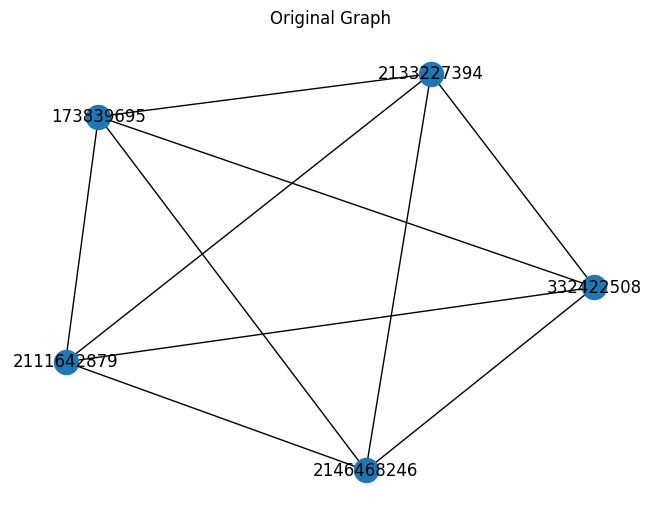

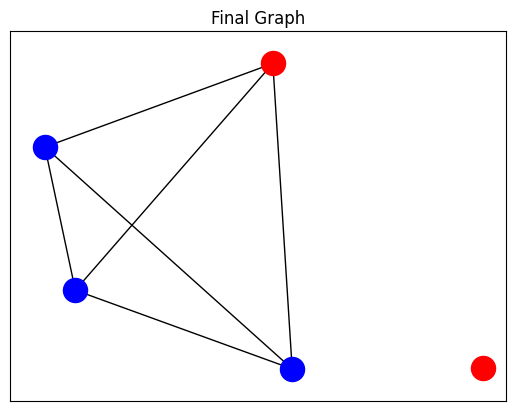

In [68]:
disconnect_frontend(5, top1, top2)

2.5 Visualize the communities

We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

- Print the number of links that should be removed to have the communities
- A table depicting the communities and the papers that belong to each community
- Plot the original graph
- Plot the graph showing the communities in the network
- Plot the final graph and identify the community/communities of Paper_1 and Paper_2


In [78]:
def communities_frontend(N, paper_1, paper_2, G_data = citation_data):
    
    # TRetrieve data from the backend function
    n_edgestodrop, current_components, same_component = extract_communities(N, paper_1, paper_2, G_data = citation_data)

    # Print the number of links that should be removed to have the communities
    print( 'The numbers of edges that has to be dropped to form communities is:', n_edgestodrop )

    # Table with communities and paper of each community

    communities_table = PrettyTable(["Community nodes"])
    for community in current_components:
        communities_table.add_row([community])
    
    # Print the tables
    print("Communities Table:")
    print(communities_table)
    


    # Original graph
    # STEP 1: retrieve data to construct the original graph as a networkx graph
    # extract graph class instance from the data in input 
    G = graph(G_data['nodes'], G_data['edges'], dict(), G_data['dir'])
    # extract top N papers 
    topN_list = extract_topN(G, N, 'papers')
    # subgraph of the top N papers
    G_N = G.extract_subgraph(topN_list)

    # STEP 2: Construct networkx Graph instance of the original graph
    Gpapers_original = nx.MultiDiGraph()
    Gpapers_original.add_nodes_from(G_N.nodes)
    Gpapers_original.add_edges_from(G_N.edges)

    # STEP 3: Plot the original graph
    plt.clf()
    nx.draw(Gpapers_original, with_labels=True)
    plt.title('Original Graph')
    plt.show()


    # Final graph and community/communities of Paper_1 and Paper_2
    # STEP1: identify the edges removed while creating the communities

    # Retrieve original connected components in the graph
    _, original_ccs = connected_components(G_N)

    # To find the removed edges, compare the original connected components with the ones retrieved from the communities
    original_ccs_set = [set(component) for component in original_ccs]
    current_components_set = [set(component) for component in current_components]

    new_components = [list[component] for component in current_components_set if component not in original_ccs_set ]
   

    # Removed edges are the ones between the newo components
    removed_edges = [edge for edge in G_N.edges if (edge[0] in new_components[0] and edge[1] in new_components[1]) or (edge[1] in new_components[0] and edge[0] in new_components[1]) ]
    
    # STEP2: crate a copy of the original graph and remove the edges removed to create communities
    Gpapers_final = Gpapers_original.copy()
    Gpapers_final.remove_edges_from(removed_edges)
    
    # Identify components of the two papers wrt same component
    if same_component: 
        # find component with the two papers
        for component in current_components:
            if paper_1 in component:
                papers_component= component
                break

        # Plot final graph
        plt.clf()
        positions = nx.random_layout(Gpapers_final)
        nx.draw_networkx_nodes(Gpapers_final, pos=positions, nodelist = papers_component, node_color = 'red')
        nx.draw_networkx_nodes(Gpapers_final, pos=positions, nodelist = [node for node in G_N.nodes if node not in papers_component], node_color = 'blue')
        nx.draw_networkx_edges(Gpapers_final)
        plt.title('Final Graph')
        plt.show()
    else: 
        # Find components of the two papers 
        for component in current_components:
            if paper_1 in component:
                component1 = component
            if paper_2 in component:
                component2 = component

        # Plot the final graph
        plt.clf()
        positions = nx.random_layout(Gpapers_final)
        nx.draw_networkx_nodes(Gpapers_final, pos= positions, nodelist = component1 , node_color = 'red')
        nx.draw_networkx_nodes(Gpapers_final, pos=positions,  nodelist = component2 , node_color = 'green')
        nx.draw_networkx_nodes(Gpapers_final, pos=positions, nodelist = [node for node in G_N.nodes if node not in component1 and node not in component2], node_color = 'blue')
        nx.draw_networkx_edges(Gpapers_final, pos= positions)
        plt.title('Final Graph')
        plt.show()

    
    


The numbers of edges that has to be dropped to form communities is: 2
Communities Table:
+--------------------------+
|     Community nodes      |
+--------------------------+
|       [2151103935]       |
|       [2156909104]       |
|       [1791587663]       |
|       [1639032689]       |
|       [2041404167]       |
|       [2161969291]       |
|       [2125055259]       |
| [2156186849, 1655990431] |
| [2147152072, 1956559956] |
|       [1996360405]       |
|       [2618530766]       |
|       [2108598243]       |
|       [2296616510]       |
|       [2147800946]       |
|       [1971784203]       |
|       [1987198869]       |
|       [2130509920]       |
|       [2159080219]       |
+--------------------------+


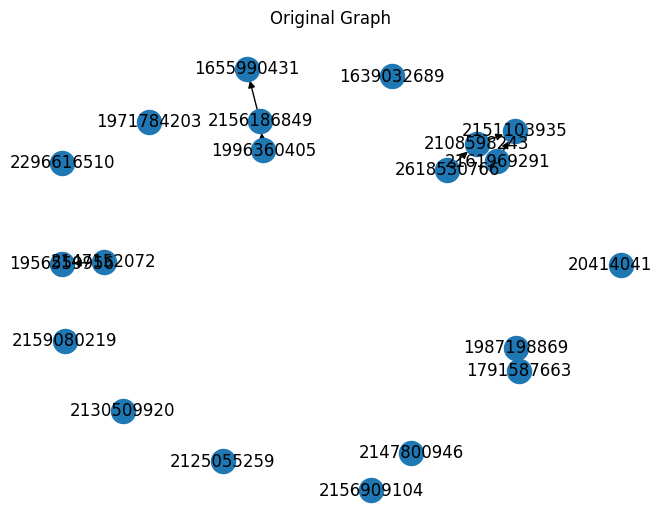

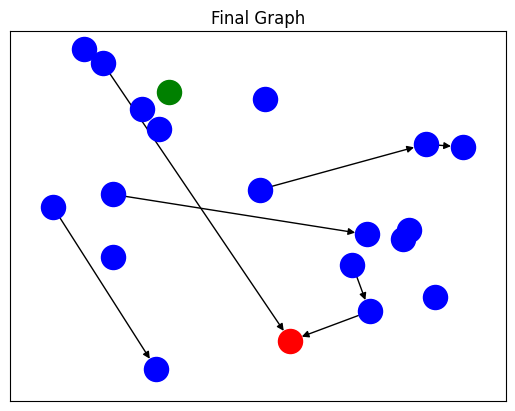

In [80]:
communities_frontend(20, topp1, topp2)